In [8]:
from math import sqrt

import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

In [4]:
dataset = pd.read_csv('data/train.tsv', sep='\t', header=0)
dataset['category_name'] = dataset['category_name'].fillna('Other').astype(str)
dataset['brand_name'] = dataset['brand_name'].fillna('missing').astype(str)
dataset['shipping'] = dataset['shipping']
dataset['item_condition_id'] = dataset['item_condition_id']
dataset['item_description'] = dataset['item_description'].fillna('None')

In [5]:
# split category into general, sub1, and sub2
categories = list(dataset['category_name'])

gencat_list = []
subcat1_list = []
subcat2_list = []

for cat in categories:
    cats = cat.split("/")
    cats[0] = cats[0].replace(' ', '')
    cats[0] = cats[0].replace('&', '_')
    if len(cats) > 1:
        cats[1] = cats[1].replace(' ', '')
        cats[1] = cats[1].replace('&', '_')
    if len(cats) > 2:
        cats[2] = cats[2].replace(' ', '')
        cats[2] = cats[2].replace('&', '_')
    gencat_list.append(cats[0].strip())
    subcat1_list.append(cats[1].strip() if len(cats) > 1 else "Other")
    subcat2_list.append(cats[2].strip() if len(cats) > 2 else "Other")

dataset["general_category"] = gencat_list
dataset["subcategory_1"] = subcat1_list
dataset["subcategory_2"] = subcat2_list
dataset.drop('category_name', axis=1, inplace=True)

In [6]:
X = dataset.loc[:, dataset.columns != 'price']
Y = np.log1p(dataset['price'])

# 80% training data, 20% test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [56]:
# % % time

preprocessor = CountVectorizer().build_preprocessor()


def build_field_preprocessor(field):
    field_idx = list(X_train.columns).index(field)
    return lambda x: preprocessor(x[field_idx])  # this preprocesses like stripping accents, etc.


class OneHotVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, column, column_name):
        # def __init__(self, preprocessor):
        self.column = column
        self.column_name = column_name

    def fit(self, X, y=None):
        self.enc = OneHotEncoder(sparse=True, handle_unknown='infrequent_if_exist')
        self.enc.fit(X[:, self.column].reshape(-1, 1))
        return self

    def transform(self, X):
        return self.enc.transform(X[:, self.column].reshape(-1, 1))

    def get_feature_names(self):
        return self.enc.get_feature_names_out([self.column_name])


vectorizer = FeatureUnion([
    ('name', TfidfVectorizer(
        ngram_range=(1, 3),
        min_df=3,
        max_features=250_000,
        preprocessor=build_field_preprocessor('name')
    )),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 3),
        min_df=5,
        max_features=500_000,
        preprocessor=build_field_preprocessor('item_description')
    )),

    *[(field, OneHotVectorizer(
        column=list(X_train.columns).index(field),
        column_name=field
    )) for field in ['brand_name', 'general_category', 'subcategory_1', 'subcategory_2',
                     'item_condition_id', 'shipping']]
])

X_train_transformed = vectorizer.fit_transform(X_train.values)
X_test_transformed = vectorizer.transform(X_test.values)

In [57]:
train_x, test_x = X_train_transformed, X_test_transformed

In [58]:
print(train_x.shape, test_x.shape)

(1186028, 755552) (296507, 755552)


100%|██████████| 9/9 [43:20<00:00, 288.93s/it]


RMSLE for alpha =  1 is 0.4472209964523648
RMSLE for alpha =  2 is 0.44169031342412035
RMSLE for alpha =  3 is 0.44087795339016006
RMSLE for alpha =  3.5 is 0.4410180255778731
RMSLE for alpha =  4 is 0.44133868064600473
RMSLE for alpha =  4.5 is 0.44175564575680937
RMSLE for alpha =  5 is 0.4422297411531966
RMSLE for alpha =  6 is 0.44332477778336404
RMSLE for alpha =  7 is 0.4444311208126605


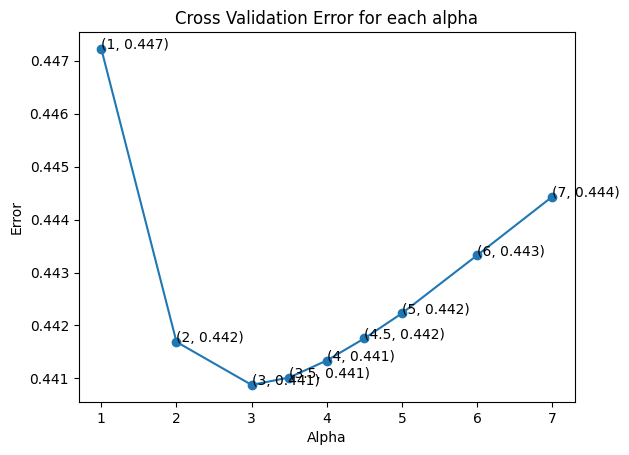

In [53]:
alpha = [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7]
test_rmsle_array = []
for i in tqdm(alpha):
    model = Ridge(solver="sparse_cg", random_state=42, alpha=i)
    model.fit(train_x, Y_train)
    preds_test = model.predict(test_x)
    test_rmsle_array.append(sqrt(mse(Y_test, preds_test)))

for i in range(len(test_rmsle_array)):
    print('RMSLE for alpha = ', alpha[i], 'is', test_rmsle_array[i])

best_alpha = np.argmin(test_rmsle_array)

fig, ax = plt.subplots()
ax.plot(alpha, test_rmsle_array)
ax.scatter(alpha, test_rmsle_array)
for i, txt in enumerate(np.round(test_rmsle_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], test_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [59]:
# best_alpha = 3
print("Best alpha: ", alpha[best_alpha])
model = Ridge(solver="sparse_cg", random_state=42, alpha=alpha[best_alpha])
model.fit(train_x, Y_train)
ridge_preds_train = model.predict(train_x)
ridge_preds_test = model.predict(test_x)

print('Train RMSLE:', sqrt(mse(Y_train, ridge_preds_train)))

ridge_rmsle = sqrt(mse(Y_test, ridge_preds_test))
print("Cross validation RMSLE: ", ridge_rmsle)

Best alpha:  3.5


/Users/marc/opt/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:830: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


Train RMSLE: 0.3840784152976513
Cross validation RMSLE:  0.44083572974616914


In [61]:
eli5.show_weights(model, vec=vectorizer, top=100)

/Users/marc/opt/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+2.895,<BIAS>
+2.083,name__apple watch
+2.060,name__tieks
+2.015,name__14k
+1.836,item_description__14k
+1.814,name__inr
+1.797,name__tyme
+1.760,brand_name__brand_name_David Yurman
+1.728,item_description__128gb
+1.704,name__mcm


In [ ]:
import pickle

# save model to disk
with open('ridge_vectorized.pkl', 'wb') as f:
    pickle.dump(model, f)